# Predictability closer to spinodal

### Packages

In [7]:
# Loading and presenting data related
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix

# Model related
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim

# Get rid of warnings
import warnings
warnings.filterwarnings('ignore')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

### Data Functions

In [3]:
class XY(object):
    def __init__(self, X_files, Y_files, L, X_pre = np.array([]), Y_pre = np.array([]), balance_prob = None, verbose = True):
        
        self.X_pre = X_pre
        self.Y_pre = Y_pre
        self.X_files = X_files
        self.Y_files = Y_files
        self.L = L
        self.verbose = verbose
        self.Y = self.ReadY()
        if not balance_prob:
            self.bin_num = 33 
            self.balance_prob = self.GetBalanceProb()
        else:
            self.bin_num = len(balance_prob)
            self.balance_prob = balance_prob
        self.X_out, self.Y_out = self.BalancedRead()
        
    def shape(self):
        return self.X_out.shape[1:]
    
    def __len__(self):
        return len(self.X_out)
    
    def ReadY(self):
        out = []
        for file in self.Y_files:
            out_file = []
            f = open(file,'r').read().split('\n')[2:-1]
            for line in f:
                if line[1] != 't':
                    out_file.append([float(line)/100, 1-float(line)/100])
            out += out_file
        out = np.asarray(out)
        return out        
    
    def GetBalanceProb(self):
        bins, borders = np.histogram(self.Y[:,0], bins = self.bin_num)

        balance_prob = [min(bins)/bins[i] for i in range(len(bins))]
        return balance_prob
    
    def BalanceReadFile(self, X_out, Y_out, count, file):
        f = open(file,'r').read().split('\n')[2:-1]
        for i in range(len(f)):
            if self.Y[count + i][0] == 1:
                if random.random() < self.balance_prob[-1]:
                    config = f[i].split()
                    config = [[(int(spin)+1)/2, 1-(int(spin)+1)/2] for spin in config]
                    config = [[config[i * self.L + j] for j in range(self.L)] for i in range(self.L)]
                    X_out.append(config)
                    Y_out.append(self.Y[count+i])
            else:
                if random.random() < self.balance_prob[int(self.Y[count + i][0] * self.bin_num)]:
                    config = f[i].split()
                    config = [[(int(spin)+1)/2, 1-(int(spin)+1)/2] for spin in config]
                    config = [[config[i * self.L + j] for j in range(self.L)] for i in range(self.L)]
                    X_out.append(config)
                    Y_out.append(self.Y[count+i])
            if self.verbose:
                print('loading file ' + file + ', [%d/%d]'%(i,len(f)), end = '\r')
        count += len(f)
        #if self.verbose:
        #    print('file ' + file + ' loading complete!  ' )
        return X_out, Y_out, count
        
    def BalancedRead(self):
        X_batch = []
        Y_batch = []
        count = 0
        
        for file in self.X_files:
            X_batch, Y_batch, count = self.BalanceReadFile(X_batch, Y_batch, count, file)
        
        X_batch, Y_batch = np.asarray(X_batch), np.asarray(Y_batch)
        X_out = np.vstack([self.X_pre, X_batch]) if X_pre.size else X_batch
        Y_out = np.vstack([self.Y_pre, Y_batch]) if Y_pre.size else Y_batch
            
        return X_out, Y_out
    
    def PlotDataHisto(self):
        plt.hist(self.Y[:,0], bins = 33, alpha = 0.5, density = True, label = r'before balance, $N_{data}$ = %d'%self.Y.shape[0] )
        plt.hist(self.Y_out[:,0], bins = 33, alpha = 0.5, density = True, label = r'after balance, $N_{data}$ = %d'%self.Y_out.shape[0])
        plt.legend(loc = 'best')
        plt.xlabel(r'$p_n$')
        plt.ylabel('probability density')
        plt.title('Data Balancing')
        plt.show()
        
class Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)
        self.X = self.X.permute(0,3,1,2).float()
        self.Y = self.Y.float()
        self.len = X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len
    
def ReadY(Y_files):
    out = []
    for file in Y_files:
        out_file = []
        f = open(file,'r').read().split('\n')[2:-1]
        for line in f:
            if line[1] != 't':
                out_file.append([float(line)/100, 1-float(line)/100])
        out += out_file
    out = np.asarray(out)
    return out  

def DensityProfile(X, num_bins = 50):
    density_profile = np.zeros([X.shape[0], int(num_bins*np.sqrt(2)+1)])
    center = X[0].shape[0]//2
    grid_per_bin = X[0].shape[0]//num_bins//2
    for k in range(X.shape[0]):
        x = X[k]
        profile = np.zeros([int(num_bins*np.sqrt(2)+1), 2])
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                profile[int(np.sqrt((i - center)**2 + (j - center)**2))//grid_per_bin][0] += x[i][j][1]
                profile[int(np.sqrt((i - center)**2 + (j - center)**2))//grid_per_bin][1] += 1
        density_profile[k] = profile[:,0]/profile[:,1]
    return density_profile

### CNN Model

In [4]:
class CNN(nn.Module):
    def __init__(self, input_length, num_layers, num_kernels, kernel_size, dropout_rate = 0.5):
        super(CNN, self).__init__()
        self.input_length = input_length
        self.num_layers = num_layers
        self.num_kernels = [2] + num_kernels
        self.conv = []
        self.dim_after_conv = self.input_length
        for i in range(self.num_layers):
            self.conv.append(nn.Conv2d(self.num_kernels[i], self.num_kernels[i+1], kernel_size))
            self.dim_after_conv = (self.dim_after_conv - kernel_size + 1)//2
        self.conv = nn.ModuleList(self.conv)
        self.dropout = nn.Dropout(p = dropout_rate)
        self.linear1 = nn.Linear(self.dim_after_conv ** 2 * num_kernels[-1], 10)
        self.linear2 = nn.Linear(10, 2)
    
    def forward(self, x):
        for i in range(self.num_layers):
            x = F.max_pool2d(F.relu(self.conv[i](x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.linear1(x))
        x = F.softmax(self.linear2(x))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
def Train(model, train_dataset, verbose = 1, EPOCHES = 10, lr = 0.001, mmt = 0.9, batch_size = 32, losses = np.array([])):
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mmt)
    
    for epoch in range(EPOCHES):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if verbose == 1:
                print('[Epoch %d], [Batch %d/%d]'%(epoch+1, i+1, len(train_dataset)//batch_size), end = '\r')
                            
        if verbose == 1 or verbose == 2:
            print('[Epoch %d]Training loss: %.3f' %(epoch + 1, running_loss / i))
        
        if losses.size:
            losses[epoch] = running_loss/i
    return model, losses

def Test(model, test_dataset, batch_size):
    
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    loss_fn = nn.BCELoss()
    
    Y_true = []
    Y_pre = []
    with torch.no_grad():
        running_loss = 0.0
        j = 0
        for i, data in enumerate(testloader, 0):
            j += 1
            inputs, labels = data
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            Y_true.append(labels)
            Y_pre.append(outputs)
        average_loss = running_loss/j
    
    Y_true = torch.cat(Y_true, 0)
    Y_pre = torch.cat(Y_pre, 0)
    return Y_true, Y_pre, loss

def VisualizePerformance(Y_true, Y_pre, loss, label, model = 'CNN', color = 'blue', alpha = 0.1, txtpos = [0.7,0.2]):
    plt.scatter(Y_true[:,0], Y_pre[:,0], marker = 'o', alpha = alpha, color = color, label = label + ' ' + model)
    plt.text(txtpos[0], txtpos[1], label +' test loss: %.3f'%loss)
    leg = plt.legend(loc = 'upper left')
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.xlabel(r'$Y_{true}$')
    plt.ylabel(r'$Y_{pre}$')
    plt.plot([0,1],[0,1], color = 'red')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(model + ' performance')

### Oclusion Method

In [6]:
class Oclusion(object):
    def __init__(self, model, X_test, Y_test, repetition = 20, patch_size = 20, bin_width = 2):
        self.model = model
        self.X_test = X_test
        self.Y_test = Y_test
        self.repetition = repetition
        self.patch_size = patch_size
        self.bin_width = bin_width
        self.L = X_test.shape[1]
        self.mapsize = (self.L-self.patch_size)//self.bin_width
        self.oclusionmap = self.OclusionTest()
        self.result = self.Smooth()
        self.intensity = self.Intensity()
        
    def OclusionTest(self):
        oclusionmap = np.zeros((self.mapsize, self.mapsize, 2))
        i = 0
        for x in self.X_test:
            i += 1
            inputs = torch.from_numpy(np.asarray([x]))
            inputs = inputs.permute(0,3,1,2).float()
            Y_original = self.model(inputs)[0][0]
            print('Oclusion test... [%d/%d]'%(i, self.X_test.shape[0]), end = '\r')
            for j in range(self.repetition):
                oc_x = int(random.random()*(self.L-self.patch_size))
                oc_y = int(random.random()*(self.L-self.patch_size))
                mapx = oc_x//self.bin_width
                mapy = oc_y//self.bin_width
                x_oc = np.copy(x)
                for m in range(oc_x, oc_x+self.patch_size):
                    for n in range(oc_y, oc_y+self.patch_size):
                        x_oc[m,n] = np.asarray([1,0])
                inputs = torch.from_numpy(np.asarray([x_oc]))
                inputs = inputs.permute(0,3,1,2).float()
                Y_ocl = self.model(inputs)[0][0]
                difference = abs(Y_original - Y_ocl)
                oclusionmap[mapx, mapy, 0] += difference
                oclusionmap[mapx, mapy, 1] += 1
        oclusionmap = oclusionmap[:,:,0]/oclusionmap[:,:,1]
        oclusionmap = np.nan_to_num(oclusionmap)
        print('Oclusion test finished!                                       ')
        return oclusionmap
    
    def Smooth(self):
        smoothed = np.copy(self.oclusionmap)
        for x in range(self.mapsize):
            for y in range(self.mapsize):
                smoothed[x,y] = self.NeighborAverage(x, y)
        return smoothed
                
    def NeighborAverage(self, x, y, window_size = 2):
        if x >= window_size and x < self.mapsize-window_size:
            if y >= window_size and y < self.mapsize-window_size:
                return np.mean(self.oclusionmap[x-window_size:x+window_size, y-window_size:y+window_size])
        return self.oclusionmap[x,y]
        
    def Intensity(self):
        num_bins = self.mapsize//2
        dist = [[] for j in range(int(num_bins*np.sqrt(2))+1)]
        for x in range(self.mapsize):
            for y in range(self.mapsize):
                dist[int(np.sqrt((x-self.mapsize//2)**2 +(self.mapsize//2-y)**2))].append(self.result[x][y])
        return np.asarray(dist)

In [129]:
a = Oclusion(trained_net_10, X_test, Y_test)

Oclusion test finished!                                       


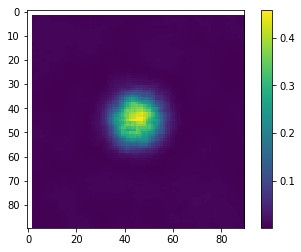

In [130]:
plt.imshow(a.result)
plt.colorbar()

### Determine which files to choose from

Using partial data to ensure dataset of different physical parameters have similar amount of data

In [7]:
def ReadY(Y_files):
    out = []
    for file in Y_files:
        out_file = []
        f = open(file,'r').read().split('\n')[2:-1]
        for line in f:
            if line[1] != 't':
                out_file.append([float(line)/100, 1-float(line)/100])
        out += out_file
    out = np.asarray(out)
    return out  

In [35]:
num_files = [[16,181], [11,146], [1, 106], [1,101], [11,96]]
num_files = [[16,151], [11,121], [1, 81], [1,81], [11,76]]
for j, label in enumerate(['R=10h=1.210', 'R=12h=1.2283', 'R=15h=1.243', 'R=18h=1.2515', 'R=20h=1.255'], 0):
    Y_files = ['CloserToSpinodal/'+label+'/L=200/interv_'+str(i)+'.txt' for i in range(num_files[j][0], num_files[j][1])]
    yyy = ReadY(Y_files)
    y_out = []
    bins, borders = np.histogram(yyy[:,0], bins=33)
    balance_prob = [min(bins)/bins[i] for i in range(len(bins))]
    for i in range(len(yyy)):
        if yyy[i][0] == 1:
            if random.random() < balance_prob[-1]:
                y_out.append(yyy[i])
        else:
            if random.random() < balance_prob[int(yyy[i][0] * 33)]:
                y_out.append(yyy[i]) 
    y_out = np.asarray(y_out)
    print(len(y_out[:,0]))    

6149
6386
6346
6396
6196


### R=10 h=1.210

In [71]:
label = 'R=10h=1.210'
Y_files = ['CloserToSpinodal/'+label+'/L=200/interv_'+str(i)+'.txt' for i in range(1, 171)]
Y = ReadY(Y_files)
bins, borders = np.histogram(Y[:,0], bins=33)
balance_prob = [min(bins)/bins[i] for i in range(len(bins))]
L = 200
#Use batch-wise data reading to make memory use more efficient 40GB->4GB!
X_pre, Y_pre= np.array([]), np.array([])
for j in range(17):
    X_files = ['CloserToSpinodal/R=10h=1.210/L=200/config_'+str(i)+'.txt' for i in range(j*10+1, (j+1)*10+1)]
    Y_files = ['CloserToSpinodal/R=10h=1.210/L=200/interv_'+str(i)+'.txt' for i in range(j*10+1, (j+1)*10+1)]
    data_10 = XY(X_files, Y_files, L, X_pre, Y_pre, balance_prob, verbose = False)
    X_pre, Y_pre = data_10.X_out, data_10.Y_out
    print(X_pre.shape, Y_pre.shape)

file CloserToSpinodal/R=10h=1.210/L=200/config_1.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_2.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_3.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_4.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_5.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_6.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_7.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_8.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_9.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_10.txt loading complete!  
(359, 200, 200, 2) (359, 2)
file CloserToSpinodal/R=10h=1.210/L=200/config_11.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_12.txt loading complete!  
file CloserToSpinodal/R=10h=1.210/L=200/config_13.txt loading complete!  
file CloserToSpinod

In [73]:
print('total number of data points %d'%(len(data_10)))
print('tensor dimensions of each data input is' + str(data_10.shape()))

total number of data points 7739
tensor dimensions of each data input is(200, 200, 2)


In [74]:
X_train, X_test, Y_train, Y_test = train_test_split(data_10.X_out,data_10.Y_out,test_size = 0.2, random_state = 42)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)

(6191, 200, 200, 2) (6191, 2) (1548, 200, 200, 2) (1548, 2)


In [75]:
net_10 = CNN(input_length = 200, num_layers =  2, num_kernels = [8,16], kernel_size = 5)
trained_net_10 = Train(net_10, train_dataset, EPOCHES = 10)

[Epoch 1]Training loss: 0.694
[Epoch 2]Training loss: 0.666
[Epoch 3]Training loss: 0.585
[Epoch 4]Training loss: 0.538
[Epoch 5]Training loss: 0.529
[Epoch 6]Training loss: 0.531
[Epoch 7]Training loss: 0.527
[Epoch 8]Training loss: 0.527
[Epoch 9]Training loss: 0.525
[Epoch 10]Training loss: 0.526


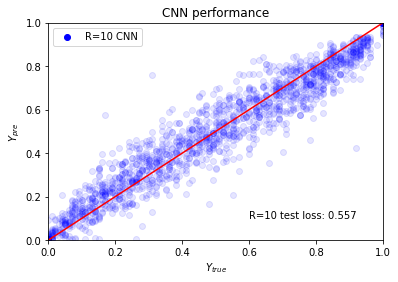

In [76]:
Y_true, Y_pre, CEloss = Test(trained_net_10, test_dataset, batch_size = 32)
VisualizePerformance(Y_true, Y_pre, CEloss, label = 'R=10', alpha = 0.1, color = 'blue', txtpos = [0.6, 0.1])

Save trained net for future use

In [140]:
torch.save(trained_net_10.state_dict(), 'CloserToSpinodal/TrainedNet/R=10h=1.210L2N8.h5')

In [141]:
neeeet = CNN(input_length = 200, num_layers =  2, num_kernels = [8,16], kernel_size = 5)
neeeet.load_state_dict(torch.load('CloserToSpinodal/TrainedNet/R=10h=1.210L2N8.h5'))

<All keys matched successfully>

Use trained net to do Oclusion

Oclusion test finished!                                       


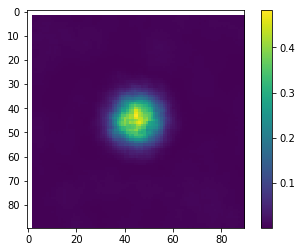

In [143]:
ocl_10 = Oclusion(neeeet, X_test, Y_test)
plt.imshow(ocl_10.result)
plt.colorbar()
plt.show()

### Apply to other interaction ranges

In [ ]:
L = 200
file_index = [[16,151,181], [12, 122, 147], [1,81,106], [1,81,101], [11,76,96]]
epoches = 20
label_list = ['R=10h=1.210', 'R=12h=1.2283', 'R=15h=1.243', 'R=18h=1.2515', 'R=20h=1.255']
oclusion_maps = []
losses = []
for j in range(5):
    f_index = file_index[j]
    label = label_list[j]
    print('Now Processing '+ label)
    Y_files = ['CloserToSpinodal/'+label+'/L=200/interv_'+str(i)+'.txt' for i in range(f_index[0], f_index[2])]
    Y = ReadY(Y_files)
    bins, borders = np.histogram(Y[:,0], bins=33)
    balance_prob = [min(bins)/bins[i] for i in range(len(bins))]
    X_pre, Y_pre= np.array([]), np.array([])
    for k in range((f_index[1]-f_index[0])//5):
        print('Reading Data.. batch[%d/%d]'%(k,(f_index[1]-f_index[0])//5), end = '\r')
        X_files = ['CloserToSpinodal/'+label+'/L=200/config_'+str(i)+'.txt' for i in range(k*5+f_index[0], (k+1)*5+f_index[0])]
        Y_files = ['CloserToSpinodal/'+label+'/L=200/interv_'+str(i)+'.txt' for i in range(k*5+f_index[0], (k+1)*5+f_index[0])]
        data_train = XY(X_files, Y_files, L, X_pre, Y_pre, balance_prob, verbose = False)
        X_pre, Y_pre = data_train.X_out, data_train.Y_out
    X_train, Y_train = data_train.X_out, data_train.Y_out
    train_dataset = Dataset(X_train, Y_train)
    print(X_train.shape, Y_train.shape)
    X_pre, Y_pre= np.array([]), np.array([])
    for k in range((f_index[2]-f_index[1])//5):
        print('Reading Data.. batch[%d/%d]'%(k,(f_index[2]-f_index[1])//5), end = '\r')
        X_files = ['CloserToSpinodal/'+label+'/L=200/config_'+str(i)+'.txt' for i in range(k*5+f_index[1], (k+1)*5+f_index[1])]
        Y_files = ['CloserToSpinodal/'+label+'/L=200/interv_'+str(i)+'.txt' for i in range(k*5+f_index[1], (k+1)*5+f_index[1])]
        data_test = XY(X_files, Y_files, L, X_pre, Y_pre, balance_prob, verbose = False)
        X_pre, Y_pre = data_test.X_out, data_test.Y_out
    X_test, Y_test = data_test.X_out, data_test.Y_out
    test_dataset = Dataset(X_test, Y_test)
    print(X_test.shape, Y_test.shape)
    net = CNN(input_length = 200, num_layers =  2, num_kernels = [8,16], kernel_size = 5)
    trained_net, loss = Train(net, train_dataset, EPOCHES = epoches)
    torch.save(trained_net.state_dict(), 'CloserToSpinodal/TrainedNet/'+label+'L2N8.h5')
    Y_true, Y_pre, CEloss = Test(trained_net, test_dataset, batch_size = 32)
    losses.append(CEloss)
    print(CEloss)
    VisualizePerformance(Y_true, Y_pre, CEloss, label = label, alpha = 0.1, color = 'blue', txtpos = [0.6, 0.1])
    plt.show()

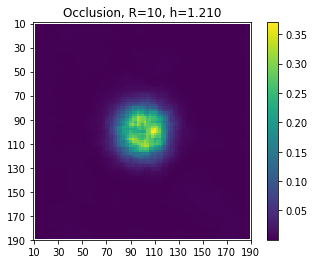

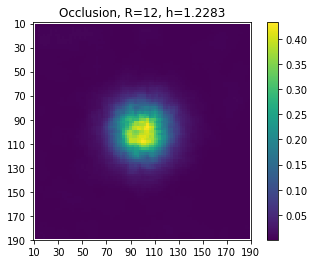

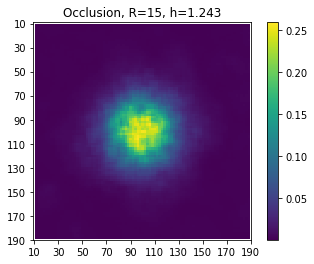

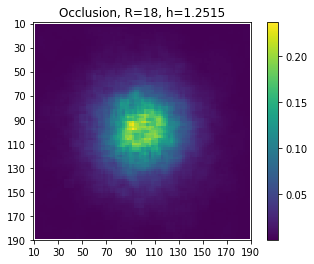

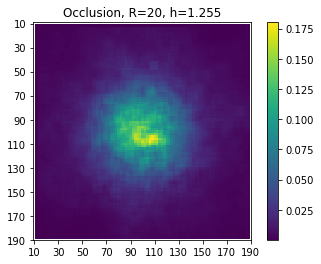

In [71]:
for j in range(5):
    label = label_list[j]
    plt.title('Occlusion, '+label[:4]+', '+label[4:])
    for x in range(oclusion_maps[j].shape[0]):
        for y in range(1):
            oclusion_maps[j][x][y] = None
    for y in range(oclusion_maps[j].shape[1]):
        for x in range(1):
            oclusion_maps[j][x][y] = None
    plt.imshow(oclusion_maps[j])
    plt.xticks(np.arange(0,ocl.mapsize+1,10), (tick * ocl.bin_width + ocl.patch_size//2 for tick in range(0,ocl.mapsize+1,10)))
    plt.yticks(np.arange(0,ocl.mapsize+1,10), (tick * ocl.bin_width + ocl.patch_size//2 for tick in range(0,ocl.mapsize+1,10)))
    plt.colorbar()
    #plt.clim([0,0.4])
    plt.show()

## Print occlusion result to file

In [104]:
file = open('occlusion_map.dat', 'w+')
ocl = np.nan_to_num(np.copy(oclusion_maps))
for j in range(5):
    file.write(label_list[j] + '\n')
    for x in range(ocl[j].shape[0]):
        for y in range(ocl[j].shape[1]):
            file.write("%.6f\t"%ocl[j][x][y])
        file.write('\n')

## Calculate Radius of gyration of occlusion intensity

In [103]:
ocl = np.nan_to_num(np.copy(oclusion_maps))
Rg = []
for i in range(5):
    sum_I = 0
    sum_m = 0
    for x in range(ocl[i].shape[0]):
        for y in range(ocl[i].shape[0]):
            sum_I += ocl[i][x][y] * ((x-ocl[i].shape[0]//2) ** 2 + (y-ocl[i].shape[0]//2) ** 2)
            sum_m += ocl[i][x][y]
    Rg.append(np.sqrt(sum_I/sum_m))
print(Rg)

[14.38144517232202, 15.143495791558163, 16.872895975513924, 19.192443196248792, 21.964899772048824]


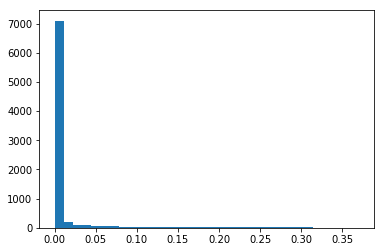

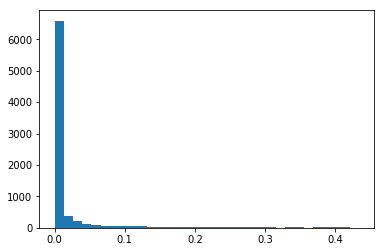

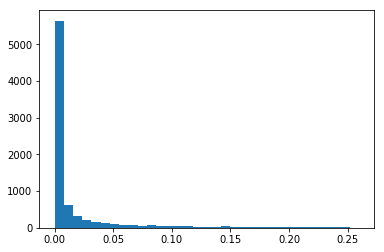

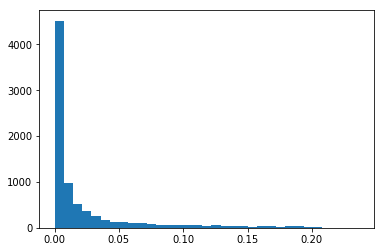

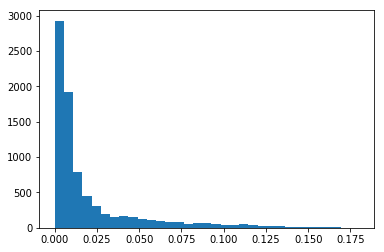

In [94]:
# Set threshold for important region
ocl = np.nan_to_num(np.copy(oclusion_maps))
for j in range(5):
    bins, borders = np.histogram(ocl[j].flatten(), bins = 33)
    plt.hist(ocl[j].flatten(), bins = 33)
    plt.show()

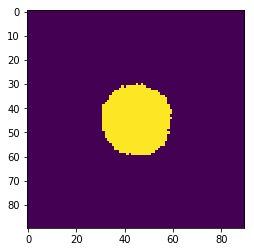

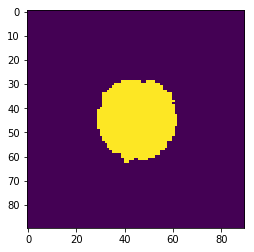

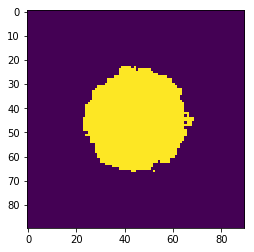

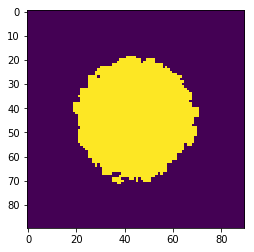

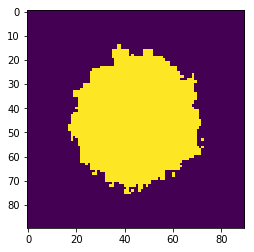

In [95]:
for i in range(5):
    threshold = np.max(ocl[i])/10
    for x in range(ocl[i].shape[0]):
        for y in range(ocl[i].shape[1]):
            if ocl[i][x][y] >= threshold:
                ocl[i][x][y] = 1
            else:
                ocl[i][x][y] = 0
    Rg = ocl[i]
    plt.imshow(ocl[i])
    plt.show()

# Try different occlusion

## Occlusion map vs. density profile

In [8]:
#file_index = [[16,181], [12,147], [1, 106], [1,101], [10,96]]
intensities = []
density_profiles = []
L = 200
oclusion_maps = []
file_index = [[16,49], [12,41], [1, 26], [1,21], [10,30]]
label_list = ['R=10h=1.210', 'R=12h=1.2283', 'R=15h=1.243', 'R=18h=1.2515', 'R=20h=1.255']
for j in range(5):
    f_index = file_index[j]
    label = label_list[j]
    print('Now Processing '+ label)
    Y_files = ['CloserToSpinodal/'+label+'/L=200/interv_'+str(i)+'.txt' for i in range(f_index[0], f_index[1])]
    Y = ReadY(Y_files)
    bins, borders = np.histogram(Y[:,0], bins=33)
    balance_prob = [min(bins)/bins[i] for i in range(len(bins))]
    model = CNN(input_length = 200, num_layers =  2, num_kernels = [8,16], kernel_size = 5)
    model.load_state_dict(torch.load('CloserToSpinodal/TrainedNet/'+label+'L2N8.h5'))
    X_pre, Y_pre= np.array([]), np.array([])
    for k in range((f_index[1]-f_index[0])//5):
        print('Reading Data.. batch[%d/%d]'%(k,(f_index[1]-f_index[0])//5), end = '\r')
        X_files = ['CloserToSpinodal/'+label+'/L=200/config_'+str(i)+'.txt' for i in range(k*5+f_index[0], (k+1)*5+f_index[0])]
        Y_files = ['CloserToSpinodal/'+label+'/L=200/interv_'+str(i)+'.txt' for i in range(k*5+f_index[0], (k+1)*5+f_index[0])]
        data = XY(X_files, Y_files, L, X_pre, Y_pre, balance_prob, verbose = False)
        X_pre, Y_pre = data.X_out, data.Y_out
    density_profiles.append(DensityProfile(data.X_out))
    #X_train, X_test, Y_train, Y_test = train_test_split(data.X_out,data.Y_out,test_size = 0.2, random_state = 42)
    #print(X_test.shape, Y_test.shape)
    #test_dataset = Dataset(X_test, Y_test)
    ocl = Oclusion(model, data.X_out, data.Y_out)
    #intensities.append(ocl.intensity)
    oclusion_maps.append(ocl.result)

Now Processing R=10h=1.210
Oclusion test finished!                                       
Now Processing R=12h=1.2283
Oclusion test finished!                                       
Now Processing R=15h=1.243
Oclusion test finished!                                       
Now Processing R=18h=1.2515
Oclusion test finished!                                       
Now Processing R=20h=1.255
Oclusion test finished!                                       


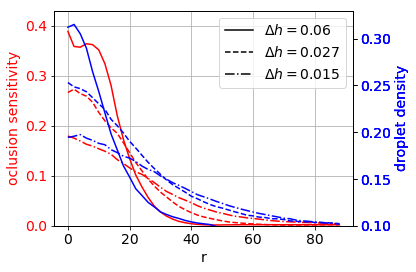

In [11]:
color_1 = ['red', 'black', 'blue', 'purple', 'black']
label_list = ['$\Delta h = 0.06$', 'R=12h=1.2283', '$\Delta h = 0.027$', 'R=18h=1.2515', '$\Delta h = 0.015$']
style = ['-', '', '--','-o-', '-.']
fig, ax1 = plt.subplots()

plt.grid()
for i in [0, 2, 4]:
    color = color_1[i]
    ax1.set_xlabel('r')
    ax1.set_ylabel('oclusion sensitivity', color='red')
    #ax1.errorbar(xs, mean_1, yerr = std_1, color=color, marker = 'o')
    ax1.plot(xs, mean_2[i], style[i], color='red', label = label_list[i])
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.set_ylim(ylim_1[i])
    leg = ax1.legend()

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel('droplet density', color='blue')  
    ax2.plot(xs, mean_1[i], style[i], color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylim(ylim_2[i])

    fig.tight_layout()  
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')
plt.savefig('/Volumes/My Passport/research/2019.02.27_InterventionML/Ising Paper/figures/OcclusionVsDensity.png', quality = 100, dpi = 1000)
plt.show()